# ML4SCI Task
This notebook demonstrates the implementation of model trained for anomaly detection on data provided for Specific Task V: Exploring Transformers

# WorkFlow
- Create `data_helper` class which return a DataFrame for The dataset which contain `data_path` column
- Split the Data into train and validation set using `train_test_split` in 90:10 ratio
- Configuration class used to set the hyperparameters
- Define `get_transforms` function for data augmentation
- Define `CustomDataset` class
- Define `PretrainedModel` class which uses **timm** to load pretrained VIT Model
- Define `train_utils` class which contain functions to get loss, optimizer, scheduler, score
- Define `Train` class which contain function for train and validation for one epoch and the train loop

In [1]:
# importing necessary library
import numpy as np
import pandas as pd
import shutil
import matplotlib.pyplot as plt
import glob
import os
from tqdm import tqdm
import timm
import cv2

# importing torch_libraries
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import StepLR
from timm.scheduler import CosineLRScheduler
from torchvision import transforms

import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Reading 2 images from each class to plot
data_sub_1 = cv2.imread('/kaggle/input/deeplense-transform/lenses/sub/image_100320807541648655929202108326967225168.jpg')
data_no_sub_1 = cv2.imread('/kaggle/input/deeplense-transform/lenses/no_sub/image_101413590224723510154660000143587270224.jpg')

Text(0.5, 1.0, 'No_Sub')

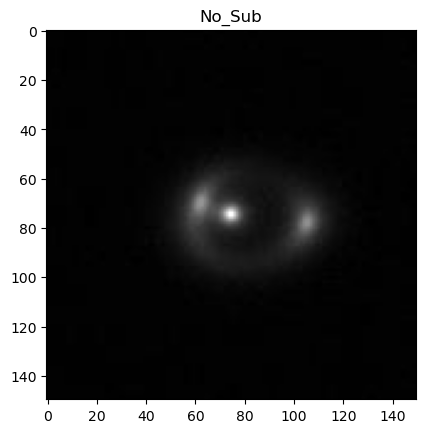

In [3]:
#plotting the image for both class
plt.imshow(data_no_sub_1)
plt.title("No_Sub")

In [4]:
# Defining directory for both file and one common directory
root_dir = '/kaggle/input/deeplense-transform/lenses'
dir_no_sub = root_dir+'/no_sub/'

In [5]:
# List for all images in the corrosponding file
path_no_sub = os.listdir('/kaggle/input/deeplense-transform/lenses/no_sub')

In [6]:
print("Length of no sub data =", len(path_no_sub))

Length of no sub data = 5000


In [7]:
# Helper function to create dataframe having target and data_path
def data_helper():
    df = pd.DataFrame()
    data_path = []
    
    for i in path_no_sub:
        data_path.append(dir_no_sub+i)
        
    df['data_path'] = data_path
    df = df.sample(frac=1, random_state=42)
    
    return df

In [8]:
data_df = data_helper()
data_df.head()

,data_path
1501,/kaggle/input/deeplense-transform/lenses/no_su...
2586,/kaggle/input/deeplense-transform/lenses/no_su...
2653,/kaggle/input/deeplense-transform/lenses/no_su...
1055,/kaggle/input/deeplense-transform/lenses/no_su...
705,/kaggle/input/deeplense-transform/lenses/no_su...


In [9]:
# Splitting the data into train and validation set with validation size = 10% 
train_df, val_df = train_test_split(data_df, test_size=0.1, random_state=2023)
train_df.head()

,data_path
941,/kaggle/input/deeplense-transform/lenses/no_su...
4208,/kaggle/input/deeplense-transform/lenses/no_su...
4260,/kaggle/input/deeplense-transform/lenses/no_su...
3853,/kaggle/input/deeplense-transform/lenses/no_su...
4306,/kaggle/input/deeplense-transform/lenses/no_su...


In [10]:
val_df.head()

,data_path
2737,/kaggle/input/deeplense-transform/lenses/no_su...
2752,/kaggle/input/deeplense-transform/lenses/no_su...
2926,/kaggle/input/deeplense-transform/lenses/no_su...
573,/kaggle/input/deeplense-transform/lenses/no_su...
447,/kaggle/input/deeplense-transform/lenses/no_su...


In [11]:
# Configuration class
class CFG:
    lr = 0.0001
    batch_size = 32
    size=[224, 224]
    epochs = 10
    seed = 42
    num_workers = 2
    transform = False
    weight_decay = 3e-5
    num_workers=2
    train=True
    debug=False
    metric_type="roc_auc"
    scheduler_type = "CosineLRScheduler"
    optimizer_type = "Adam"
    loss_type = "MSELoss"
    max_grad_norm = 1000
    lr_max = 3e-4
    epochs_warmup = 1.0
    model_name = "vit_base_patch16_224"

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
# If Debug is set to true and then it reduce the size of data to check the implementation immediatly
if CFG.debug==True:
    train_df = train_df[:100]
    val_df = val_df[:100]

In [14]:
# Augmentation
def get_transforms(*, data):
    
    if data == 'train':
        return A.Compose([
            A.Resize(*CFG.size),
            A.Rotate(limit=20),
#             A.InvertImg(), 
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Normalize(
                mean = [0.485, 0.456, 0.406],
                std = [0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

    elif data == 'valid':
        return A.Compose([
            A.Resize(*CFG.size),
            A.Normalize(
                mean = [0.485, 0.456, 0.406],
                std = [0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])


In [15]:
# Pytorch dataset creation
class CustomDataset(Dataset):

    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_path = self.df['data_path']
        image = cv2.imread(image_path.iloc[idx]).astype(np.float32)
        if self.transform is not None:
            augmented = self.transform(image=image)
            image = augmented['image']
        return torch.tensor(image)

In [16]:
# Helper Function
class AverageMeter:
    """
    Computes and stores the average and current value
    """

    def __init__(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [17]:
# Checking dataset
dataa = CustomDataset(train_df, transform=get_transforms(data='train'))
img= dataa[4]
print(img.shape)

torch.Size([3, 224, 224])


In [18]:
# Pretrained model class
class PretrainedModel(nn.Module):
    def __init__(self, pretrained=False):
        super(PretrainedModel, self).__init__()
        self.backbone = timm.create_model(CFG.model_name, pretrained=pretrained, num_classes=0)
        self.decoder = nn.Linear(self.backbone.num_features, 3 * 224 ** 2)

    def forward(self, x):
        # Encode input image using pre-trained ViT backbone
        encoded = self.backbone(x)

        # Decode encoded image to obtain reconstructed image
        decoded = self.decoder(encoded.view(-1, self.backbone.num_features))
        decoded = decoded.view(-1, 3, 224, 224)

        # Compute mean absolute error between input and reconstructed image
        loss = torch.mean(torch.abs(x - decoded), dim=[1, 2, 3])
        return loss, decoded

In [19]:
# Class containing loss, optimizer, scheduler and score method
class train_utils():
    def __init__(self, CFG):
        super().__init__()
        self.CFG = CFG
    
    # Defining the Loss Function
    def get_criterion(self):
        if self.CFG.loss_type == "CrossEntropyLoss":
            criterion = nn.CrossEntropyLoss()
        elif self.CFG.loss_type == "BCEWithLogitsLoss":
            criterion = nn.BCEWithLogitsLoss()
        elif self.CFG.loss_type == "CosineEmbeddingLoss":
            criterion = nn.CosineEmbeddingLoss()
        elif self.CFG.loss_type == "MSELoss":
            criterion = nn.MSELoss()
        return criterion
    
    # Defining the Score Function
    def get_score(self, y_true, y_pred):
        if self.CFG.metric_type == "accuracy_score":
            score =  accuracy_score(y_true, y_pred)
        elif self.CFG.metric_type == "roc_auc":
            score =  roc_auc_score(y_true, y_pred, multi_class="ovr")
        return score
    
    # Defining the Optimizer Function
    def get_optimizer(self, model):
        if self.CFG.optimizer_type == 'Adam':
            optimizer = torch.optim.Adam(model.parameters(), lr=CFG.lr_max, weight_decay=CFG.weight_decay, amsgrad=False)
        if self.CFG.optimizer_type == 'AdamW':
            optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.lr_max, weight_decay=CFG.weight_decay)
        return optimizer
    
    # Defining the Scheduler Function
    def get_scheduler(self, optimizer, warmup, nsteps):
        if self.CFG.scheduler_type == "StepLR":
            scheduler = StepLR(optimizer, step_size=2, gamma=0.1, verbose=True)
        if self.CFG.scheduler_type == 'CosineLRScheduler':
            scheduler = CosineLRScheduler(optimizer,
                                          warmup_t=warmup, warmup_lr_init=0.0, warmup_prefix=True,
                                          t_initial=(nsteps - warmup), lr_min=1e-6)
        return scheduler

In [20]:
class Train():
    def __init__(self, CFG):
        super().__init__()
        self.CFG = CFG  
    
    # Function to train one epoch
    def train_fn(self, train_loader, model, criterion, optimizer, epoch, scheduler, device):
        model.train() # switch to training mode
        nbatch = len(train_loader)
        running_loss = AverageMeter()
        for ibatch, (images) in enumerate(tqdm(train_loader, desc="Train")):
            # Load image and labels
            images = images.to(device)
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            
            # forward pass: compute predicted outputs by passing inputs to the model
            output, _ = model(images)
            bs = images.size(0)
           
            # calculate the loss
            loss = criterion(output, torch.zeros_like(output))
            running_loss.update(loss.item(), bs)

            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            optimizer.step()
            
            if self.CFG.scheduler_type == "CosineLRScheduler":
                scheduler.step(epoch * nbatch + ibatch + 1)

        return running_loss.avg

    # Function to validate one epoch
    def valid_fn(self, valid_loader, model, criterion, device):
        model.eval() # switch to evaluation mode
        running_loss = AverageMeter()

        for images in tqdm(valid_loader, desc="Validation"):
            images = images.to(device)
            bs = images.size(0)

            # compute loss
            with torch.no_grad():
                output, _ = model(images)
            loss = criterion(output, torch.zeros_like(output))
            running_loss.update(loss.item(), bs)
            # record accuracy
        return running_loss.avg
    
    # Train loop
    def train_loop(self, train_data, valid_data):

        # create dataset
        train_dataset = CustomDataset(train_data, transform=get_transforms(data='train'))
        valid_dataset = CustomDataset(valid_data, transform=get_transforms(data="valid"))

        # create dataloader
        train_loader = DataLoader(dataset=train_dataset, batch_size=self.CFG.batch_size, shuffle=True, 
                                  num_workers=self.CFG.num_workers, pin_memory=True, drop_last=False)
        valid_loader = DataLoader(dataset=valid_dataset, batch_size=self.CFG.batch_size, shuffle=False, 
                                  num_workers=self.CFG.num_workers, pin_memory=True, drop_last=False)

        # create model and transfer to device
        model = PretrainedModel(pretrained=True)
        model.to(device)
        
        # Creating object of train_utils
        train_obj = train_utils(self.CFG)
        # select optimizer, scheduler and criterion
        nbatch = len(train_loader)
        warmup = self.CFG.epochs_warmup*nbatch
        nsteps = 4*nbatch
        optimizer = train_obj.get_optimizer(model)
        scheduler = train_obj.get_scheduler(optimizer, warmup, nsteps)
        criterion = train_obj.get_criterion()

        best_loss = np.inf
        
        train_loss = []
        val_loss = []
        # start training
        for epoch in range(self.CFG.epochs):
            print("Epoch:", epoch+1)
            # train
            avg_loss = self.train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device)
            # validation
            avg_val_loss = self.valid_fn(valid_loader, model, criterion, device)
            
            if self.CFG.scheduler_type == "StepLR":
                scheduler.step()
            
            print(f"train_loss = {avg_loss}, val_loss = {avg_val_loss}")
            if avg_val_loss<best_loss:
                torch.save({'model': model.state_dict(),
                            'optimizer': optimizer.state_dict(),
                            'scheduler': scheduler.state_dict()},
                            './'+f'{self.CFG.model_name}_best.pth')
                best_loss = avg_val_loss
            train_loss.append(avg_loss)
            val_loss.append(avg_val_loss)

        print("Best Model written")
        return train_loss, val_loss

In [21]:
# main
def main():
    
    if CFG.train: 
        # train
        train = Train(CFG)
        train_loss, val_loss = train.train_loop(train_df, val_df)
    return train_loss, val_loss

In [22]:
torch.cuda.empty_cache()
import gc
gc.collect()

42

In [23]:
if __name__=='__main__':
    train_loss, val_loss = main()

Epoch: 1


Validation: 100%|██████████| 16/16 [00:03<00:00,  4.99it/s]


train_loss = 0.7265529230195615, val_loss = 0.004142821595072746
Epoch: 2


Validation: 100%|██████████| 16/16 [00:03<00:00,  5.06it/s]


train_loss = 0.0037008771780464383, val_loss = 0.003220665132626891
Epoch: 3


Validation: 100%|██████████| 16/16 [00:03<00:00,  5.11it/s]


train_loss = 0.00321799749115275, val_loss = 0.003043741596862674
Epoch: 4


Validation: 100%|██████████| 16/16 [00:03<00:00,  5.06it/s]


train_loss = 0.003027848850314816, val_loss = 0.0029974819254130125
Epoch: 5


Validation: 100%|██████████| 16/16 [00:03<00:00,  5.10it/s]


train_loss = 0.003006055214131872, val_loss = 0.0029961865451186894
Epoch: 6


Validation: 100%|██████████| 16/16 [00:03<00:00,  5.02it/s]


train_loss = 0.0030072176030112637, val_loss = 0.0029964932929724456
Epoch: 7


Validation: 100%|██████████| 16/16 [00:03<00:00,  5.13it/s]


train_loss = 0.0030071883257478476, val_loss = 0.0029957369156181812
Epoch: 8


Validation: 100%|██████████| 16/16 [00:03<00:00,  5.08it/s]


train_loss = 0.003006283173337579, val_loss = 0.0029945809300988913
Epoch: 9


Validation: 100%|██████████| 16/16 [00:03<00:00,  5.02it/s]


train_loss = 0.003005778120416734, val_loss = 0.002993799602612853
Epoch: 10


Validation: 100%|██████████| 16/16 [00:03<00:00,  5.06it/s]

train_loss = 0.0030062641536609995, val_loss = 0.0029938569348305463
Best Model written


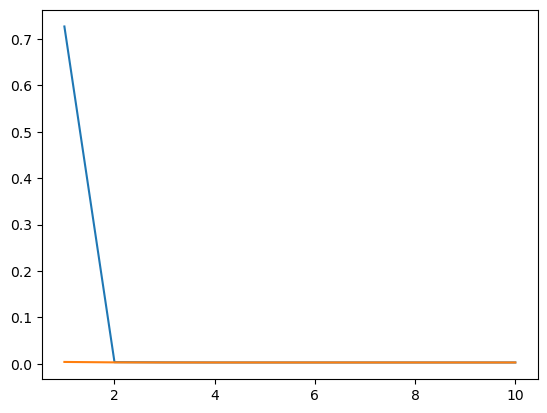

In [24]:
epoch_list = []
for i in range(CFG.epochs):
    epoch_list.append(i+1)
plt.plot(epoch_list, train_loss)
plt.plot(epoch_list, val_loss)

# Conclusion
To detect anomalies in test(val) images we have to set a threshold for the loss and then pass the image to the trained vision transformer model and calculate the loss between the original image and reconstructed image if the loss is greater then threshold then we can say it is anomaly. 